In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MultipleLocator
import scipy.stats as stats
from scipy.stats import ttest_ind, f_oneway, shapiro, levene, kruskal
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
df = pd.read_csv('survey_data_clean.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'survey_data_clean.csv'

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

## Data pre-processing

In [ ]:
df['Age'].values

In [ ]:
# Create a numeric age column to use in heatmap
age_mapping = {
    'Under 18 years old': 0,
    '18-24 years old': 1,
    '25-34 years old': 2,
    '35-44 years old': 3,
    '45-54 years old': 4,
    '55-64 years old': 5,
    '65 years or older': 6
}

df['AgeGroup'] = df['Age'].map(age_mapping)

In [ ]:
df.sample()

In [ ]:
df['EdLevel'].unique()

In [ ]:
# Create numeric value for education level

education_level_mapping = {
    'Something else': 0,
    'Primary/elementary school': 1,
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2,
    'Some college/university study without earning a degree': 3,
    'Associate degree (A.A., A.S., etc.)': 4,
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5,
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 6,
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 7
}

df['EdLevel_numeric'] = df['EdLevel'].map(education_level_mapping)


In [ ]:
df.sample()

In [ ]:
df.dtypes

In [ ]:
# Shorten education level names
education_title_mapping = {
    'Something else': 'Something else',
    'Primary/elementary school': 'Primary school',
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 'Secondary school',
    'Some college/university study without earning a degree': 'Some college study,no degree',
    'Associate degree (A.A., A.S., etc.)': 'Associate degree',
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'Bachelor’s degree',
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'Master’s degree',
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 'Professional degree'
}

In [ ]:
df['EdLevel'] = df['EdLevel'].map(education_title_mapping)

In [ ]:
# Fix negative values in work experience
negative_vals = df[df['WorkExp']<0]
negative_vals

In [ ]:
df['WorkExp'] = df.apply(lambda row: row['YearsCode'] if row['WorkExp'] < 0 else row['WorkExp'], axis=1)
df['YearsCodePro'] = df.apply(lambda row: row['YearsCode'] if row['YearsCodePro'] < 0 else row['YearsCodePro'], axis=1)


In [ ]:
df.describe(include='all')

## Task 1:
Build upon the EDA from Week 1 to conduct a more detailed Explanatory Data Analysis. This should include both Univariate and Bivariate analyses, and you should make sure to visually represent your findings.

### Univariate analysis

#### Education level of working developers

In [ ]:
education_counts = df['EdLevel'].value_counts()
education_counts

In [ ]:
plt.figure(figsize=(8, 4))
x = education_counts.index
y = education_counts.values
plt.bar(x, y)
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.title('Education Level of Working Developers')
plt.xticks(rotation=90)

plt.savefig('Ed_level.png')
plt.show()

#### Annual compensation of working developers

In [ ]:
df_filtered = df[df['ConvertedCompYearly'] < 500000]
plt.figure(figsize=(10, 6))
df_filtered['ConvertedCompYearly'].hist(bins=30)
plt.xlabel('Converted Compensation Yearly $')
plt.ylabel('Frequency')
plt.title('Histogram of Yearly Compensation Distribution for earners less than $500k')
plt.gca().xaxis.set_major_locator(MultipleLocator(100000))
plt.savefig('compensation_under_500k.png')
plt.show()

In [ ]:
# Age of developers
df['Age'].value_counts()

In [ ]:
# How did people learn to code?

In [ ]:
# Explode data from LearnCode for analysis

In [ ]:
learning_styles = df['LearnCode'].reset_index()
learning_styles.head()

In [ ]:
learning_styles = learning_styles['LearnCode'].str.split(';').explode().str.split().apply(' '.join)
learning_styles.head()

In [ ]:
learning_styles = learning_styles.value_counts().reset_index()
learning_styles

In [ ]:
color_palette = [
    "#003f5c",  # Dark Blue
    "#2f4b7c",  # Blue
    "#665191",  # Dark Purple
    "#a05195",  # Purple
    "#d45087",  # Pink
    "#f95d6a",  # Coral
    "#ff7c43",  # Orange
    "#ffa600",  # Yellow
    "#FBE97B",  # Light yellow
    "#89CFF0"   # Light blue
]
labels = ['Other' if 'Other (please specify):' in x else x for x in learning_styles['LearnCode']]

plt.pie(learning_styles['count'], labels=labels,colors = color_palette,  autopct='%0.1f%%', radius=1.8)
plt.title('How do developers learn to code?', y=1.3)
plt.show()

In [ ]:
# How many developers learned coding at least partly at school
proportion_school = df[df['LearnCode'].str.contains('School')]
proportion_school = len(proportion_school) / len(df)
proportion_school

51% of developers mentioned learning coding at school

### Bivariate analysis

In [ ]:
# Age vs salary

# Exclude top 1% from the box plots to make them more readable
salary_threshold = df['ConvertedCompYearly'].quantile(0.99)
df_filtered = df[df['ConvertedCompYearly'] <= salary_threshold]


plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='AgeGroup', y='ConvertedCompYearly', data=df_filtered)
plt.xlabel('Age Group')
plt.ylabel('Salary')
plt.title('Salary Distribution by Age Group')
plt.xticks(rotation=90)

unique_age_groups = df['AgeGroup'].unique()
labels = [
    'Under 18 years old',
    '18-24 years old',
    '25-34 years old',
    '35-44 years old',
    '45-54 years old',
    '55-64 years old',
    '65 years or older'
]
ticks = range(len(labels))
ax.set_xticks(ticks)
ax.set_xticklabels(labels)


plt.show()

In [ ]:
# Ed level vs salary

plt.figure(figsize=(12, 6))
sns.violinplot(x='EdLevel', y='ConvertedCompYearly', data=df_filtered)
plt.xlabel('Education Level')
plt.ylabel('Salary')
plt.title('Salary Distribution by Education Level')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Years worked vs salary (comparing school and non-school routes)
# Does more work experience = more pay? Is this the same for traditional/non-traditional routes?

In [ ]:
school = df[df['LearnCode'].str.contains('School')]
non_school = df[~df['LearnCode'].str.contains('School')]

# find mean salary for each year worked and plot
school_salary_mean = school.groupby('WorkExp').ConvertedCompYearly.mean().reset_index()
non_school_salary_mean = non_school.groupby('WorkExp').ConvertedCompYearly.mean().reset_index()

print(school_salary_mean)
print(non_school_salary_mean)

In [ ]:
# Round and group salaries for each year to make graph clearer
school_salary_mean['WorkExp'] = school_salary_mean['WorkExp'].round()
non_school_salary_mean['WorkExp'] = non_school_salary_mean['WorkExp'].round()

In [ ]:
school_salary_mean = school_salary_mean.groupby('WorkExp', as_index=False)['ConvertedCompYearly'].mean()
non_school_salary_mean = non_school_salary_mean.groupby('WorkExp', as_index=False)['ConvertedCompYearly'].mean()

In [ ]:
plt.plot(school_salary_mean['WorkExp'], school_salary_mean['ConvertedCompYearly'], label='Developers who learned at school')
plt.plot(non_school_salary_mean['WorkExp'], non_school_salary_mean['ConvertedCompYearly'], label='Developers who took alternative routes')

plt.title('Comparison of Annual Salary by Work Experience')
plt.xlabel('Years of Work Experience')
plt.ylabel('Annual Salary (USD)')

plt.legend()
plt.show()

In [ ]:
school_salary_mean['RollingMean'] = school_salary_mean['ConvertedCompYearly'].rolling(window=5).mean()
non_school_salary_mean['RollingMean'] = non_school_salary_mean['ConvertedCompYearly'].rolling(window=5).mean()

# Plot the original mean salary and the rolling mean
plt.figure(figsize=(12, 6))
plt.plot(non_school_salary_mean['WorkExp'], non_school_salary_mean['RollingMean'], label='Non-school developers')
plt.plot(school_salary_mean['WorkExp'], school_salary_mean['RollingMean'], label='Developers who followed school route')

plt.title('Comparison of Rolling Mean Annual Salary by Work Experience')
plt.xlabel('Years of Work Experience')
plt.ylabel('Rolling Mean Annual Salary (USD)')
plt.legend()

## Task 2:
Identify several hypotheses related to your problem based on your EDA, and perform appropriate statistical tests (e.g., t-test, chi-square test) to test these hypotheses. You should correctly interpret the results, including p-values and confidence intervals.

In [ ]:
# Research question: Does a higher the education level mean higher salary?
# Null hypothesis: education has no impact on salary
# Alternative hypothesis: educarion level impacts salary

In [ ]:
anova_result = stats.f_oneway(
    df[df['EdLevel_numeric'] == 0]['ConvertedCompYearly'],
    df[df['EdLevel_numeric'] == 1]['ConvertedCompYearly'],
    df[df['EdLevel_numeric'] == 2]['ConvertedCompYearly'],
    df[df['EdLevel_numeric'] == 3]['ConvertedCompYearly'],
    df[df['EdLevel_numeric'] == 4]['ConvertedCompYearly'],
    df[df['EdLevel_numeric'] == 5]['ConvertedCompYearly'],
    df[df['EdLevel_numeric'] == 6]['ConvertedCompYearly'],
    df[df['EdLevel_numeric'] == 7]['ConvertedCompYearly']
)

print('ANOVA result:', anova_result)
if pvalue < 0.05:
  print('Null hypothesis that education has no impact on salary is rejected')

ANOVA result: F_onewayResult(statistic=48.519043921370496, pvalue=3.160978256440639e-69)


**Interpretation of Anova Test**
1. F-statistic (statistic=48.519043921370496):<br>
- This value indicates the ratio of variance between the groups (education levels) to the variance within the groups.
- 48.52 is quite large, suggesting a significant amount of variation between the group means relative to the variation within the groups.
  
2. p-value (pvalue=3.160978256440639e-69):<br>
- The p-value is effectively zero (3.16e-69), which is far below any conventional significance level (e.g., 0.05).
- This means we can reject the null hypothesis that all the group means are equal.

**Conclusion**
- The results of the ANOVA test suggest that there are significant differences in salary among the different education levels.
- Education level does have a significant impact on salary, supporting the hypothesis that "The higher the education level, the more you get paid."

In [ ]:
tukey_result = pairwise_tukeyhsd(df['ConvertedCompYearly'], df['EdLevel'])

print(tukey_result)

                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                            
           group1                       group2              meandiff  p-adj     lower       upper    reject
-----------------------------------------------------------------------------------------------------------
            Associate degree            Bachelor’s degree   6799.8476 0.0005   1968.6025  11631.0928   True
            Associate degree              Master’s degree   5703.2472 0.0114    750.1053  10656.3892   True
            Associate degree               Primary school  -5020.1454 0.8989 -16718.4169   6678.1261  False
            Associate degree          Professional degree  14695.0876    0.0   8380.7524  21009.4228   True
            Associate degree             Secondary school -10314.8532    0.0 -16227.0699  -4402.6365   True
            Associate degree Some college study,no degree   -345.3038    1.0  -5598.2543   4907.6467  False
            Associate degree

## Tukey test

### Key to Columns in the Output:
- group1 and group2: The two education level groups being compared.
- meandiff: The difference in means between the two groups.
- p-adj: The adjusted p-value for the comparison. (If this value is below significance level of 0.05, the difference between the groups is considered statistically significant.)
- lower and upper: The lower and upper bounds of the confidence interval for the mean difference.
- reject: A boolean indicating whether the null hypothesis (that there is no difference between the group means) is rejected. True means the difference is statistically significant.

### Summary of Findings:
#### Significant Differences (reject=True):
1. Associate degree vs. Bachelor’s degree
- Mean Difference: 6799.8476
- p-adj: 0.0005
  
2. Associate degree vs. Master’s degree
- Mean Difference: 5703.2472
- p-adj: 0.0114

3. Associate degree vs. Professional degree
- Mean Difference: 14695.0876
- p-adj: 0.0

4. Associate degree vs. Secondary school
- Mean Difference: -10314.8532
- p-adj: 0.0

5. Associate degree vs. Something else
- Mean Difference: -11932.2111
- p-adj: 0.0014

6. Bachelor’s degree vs. Primary school
- Mean Difference: -11819.9931
- p-adj: 0.0204

7. Bachelor’s degree vs. Professional degree
- Mean Difference: 7895.24
- p-adj: 0.0

8. Bachelor’s degree vs. Secondary school
- Mean Difference: -17114.7008
- p-adj: 0.0

9. Bachelor’s degree vs. Some college study, no degree
- Mean Difference: -7145.1515
- p-adj: 0.0

10. Bachelor’s degree vs. Something else
- Mean Difference: -18732.0587
- p-adj: 0.0

11. Master’s degree vs. Professional degree
- Mean Difference: 8991.8404
- p-adj: 0.0

12. Master’s degree vs. Secondary school
- Mean Difference: -16018.1004
- p-adj: 0.0

13. Master’s degree vs. Some college study, no degree
- Mean Difference: -6048.551
- p-adj: 0.0

14. Master’s degree vs. Something else
- Mean Difference: -17635.4583
- p-adj: 0.0

15. Primary school vs. Professional degree
- Mean Difference: 19715.233
- p-adj: 0.0

16. Professional degree vs. Secondary school
- Mean Difference: -25009.9408
- p-adj: 0.0

17. Professional degree vs. Some college study, no degree
- Mean Difference: -15040.3914
- p-adj: 0.0

18. Professional degree vs. Something else
- Mean Difference: -26627.2987
- p-adj: 0.0

19. Secondary school vs. Some college study, no degree
- Mean Difference: 9969.5494
- p-adj: 0.0

20. Some college study, no degree vs. Something else
- Mean Difference: -11586.9073
- p-adj: 0.0003

#### Non-Significant Differences (reject=False):
1. Associate degree vs. Primary school
- Mean Difference: -5020.1454
- p-adj: 0.8989

2. Associate degree vs. Some college study, no degree
- Mean Difference: -345.3038
- p-adj: 1.0

3. Bachelor’s degree vs. Master’s degree
- Mean Difference: -1096.6004
- p-adj: 0.7365

4. Master’s degree vs. Primary school
- Mean Difference: -10723.3926
- p-adj: 0.0554

5. Primary school vs. Secondary school
- Mean Difference: -5294.7078
- p-adj: 0.8494

6. Primary school vs. Some college study, no degree
- Mean Difference: 4674.8416
- p-adj: 0.9031

7. Primary school vs. Something else
- Mean Difference: -6912.0657
- p-adj: 0.7564

8. Secondary school vs. Something else
- Mean Difference: -1617.3579
- p-adj: 0.9991

### Education Level Impact:
Higher education levels (like Bachelor’s, Master’s, and Professional degrees) generally correspond to higher salaries, with many of these differences being statistically significant.


In [ ]:
# Hypothesis: People from traditional routes get paid more than those from non-traditional
school = df[df['LearnCode'].str.contains('School')]
non_school = df[~df['LearnCode'].str.contains('School')]

print(school.shape)
print(non_school.shape)

(32187, 37)
(31427, 37)


In [ ]:
school_salaries = school['ConvertedCompYearly']
non_school_salaries = non_school['ConvertedCompYearly']

In [ ]:
# Perform the independent t-test
t_stat, p_value = ttest_ind(school_salaries, non_school_salaries, equal_var=False)

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

T-Statistic: 4.178622825231661
P-Value: 2.9367071647662336e-05


**Conclusion:**
1. Statistical Significance:
- Since the p-value (0.000029367) is much smaller than the significance level of 0.05, we can reject the null hypothesis.
- This means that there is a statistically significant difference in salaries between people who learned coding through school and those who did not.

2. Direction of the Difference:
- The positive t-statistic suggests that the mean salary of the "school" group is higher than that of the "non-school" group.

3. Summary:
- People who learned coding through school have a significantly higher mean salary compared to those who did not learn coding through school, according to the data you provided.
- The difference in compensation is unlikely to be due to random chance.

In [ ]:
# Hypothesis: The more years you have worked, the more you will get paid
# Null Hypothesis : There is no correlation between years of work experience and salary
# Alternative Hypothesis: There is a positive correlation between years of work experience and salary

In [ ]:
df['WorkExp'] = df['WorkExp'].round()

grouped_df = df.groupby('WorkExp', as_index=False)['ConvertedCompYearly'].mean()
correlation, p_value = stats.pearsonr(grouped_df['WorkExp'], grouped_df['ConvertedCompYearly'])


print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.7863159379436266
P-value: 8.059557359820445e-12


In [ ]:
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant positive correlation between years of work experience and salary.")
else:
    print("Fail to reject the null hypothesis. There is no significant correlation between years of work experience and salary.")

Reject the null hypothesis. There is a significant positive correlation between years of work experience and salary.


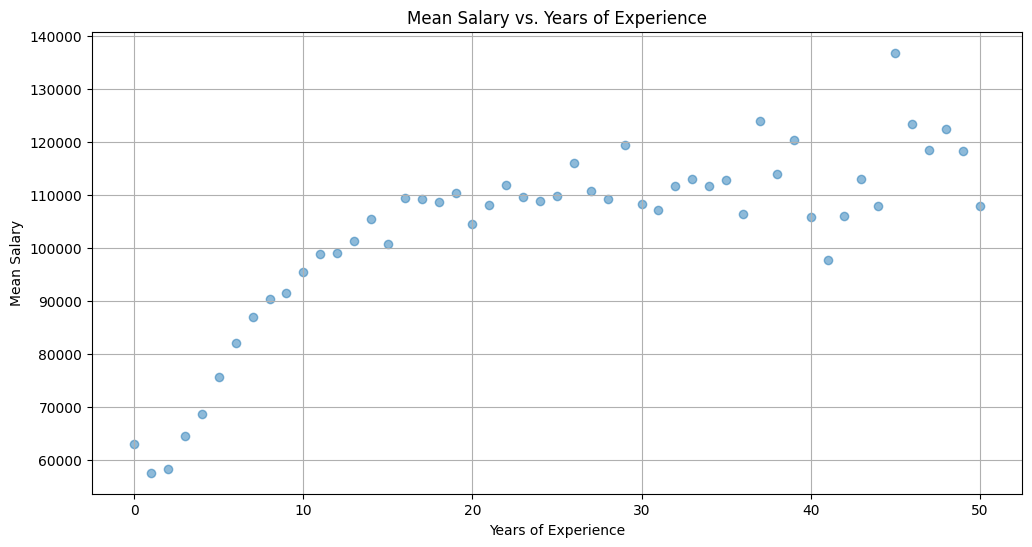

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(grouped_df['WorkExp'], grouped_df['ConvertedCompYearly'], label='Mean Salary', alpha=0.5)
plt.xlabel('Years of Experience')
plt.ylabel('Mean Salary')
plt.title('Mean Salary vs. Years of Experience')
plt.grid(True)
plt.show()

In [ ]:
# Hypothesis: Developers in different industries get paid differently

In [ ]:
df['Industry'].unique()

array(['Information Services, IT, Software Development, or other Technology',
       'Other', 'Financial Services',
       'Manufacturing, Transportation, or Supply Chain',
       'Retail and Consumer Services', 'Higher Education',
       'Legal Services', 'Insurance', 'Healthcare', 'Oil & Gas',
       'Wholesale', 'Advertising Services'], dtype=object)

In [ ]:
# Checking assumptions
print("Normality Test:")
for industry in df['Industry'].unique():
    stat, p = shapiro(df[df['Industry'] == industry]['ConvertedCompYearly'])
    print(f'Industry: {industry}, W-statistic: {stat}, p-value: {p}')

# Perform Kruskal-Wallis H-test
salary_groups = [df[df['Industry'] == industry]['ConvertedCompYearly'] for industry in df['Industry'].unique()]
statistic, p_value = kruskal(*salary_groups)

print(f"\nKruskal-Wallis H-statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in salaries across different industries.")
else:
    print("There is no significant difference in salaries across different industries.")


Normality Test:
Industry: Information Services, IT, Software Development, or other Technology, W-statistic: 0.6539202928543091, p-value: 0.0
Industry: Other, W-statistic: 0.7263314723968506, p-value: 0.0
Industry: Financial Services, W-statistic: 0.7166123390197754, p-value: 0.0
Industry: Manufacturing, Transportation, or Supply Chain, W-statistic: 0.7159285545349121, p-value: 0.0
Industry: Retail and Consumer Services, W-statistic: 0.8633925318717957, p-value: 4.583880901286449e-37
Industry: Higher Education, W-statistic: 0.6563832759857178, p-value: 5.300853130584576e-38
Industry: Legal Services, W-statistic: 0.5652858018875122, p-value: 5.782735651827254e-22
Industry: Insurance, W-statistic: 0.9184231758117676, p-value: 2.3045493816056523e-18
Industry: Healthcare, W-statistic: 0.9181085228919983, p-value: 7.968685608179094e-32
Industry: Oil & Gas, W-statistic: 0.8629900813102722, p-value: 8.755611524430967e-14
Industry: Wholesale, W-statistic: 0.6742041110992432, p-value: 6.68174661

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Kruskal-Wallis H-statistic: 268.3169372194868
P-value: 4.0350118186521265e-51
There is a significant difference in salaries across different industries.


In [ ]:
print(df.groupby('Industry')['ConvertedCompYearly'].describe())

                                                      count           mean  \
Industry                                                                     
Advertising Services                                  745.0  103047.241611   
Financial Services                                   4132.0   99498.656341   
Healthcare                                           2030.0   94565.056650   
Higher Education                                      840.0   75566.766667   
Information Services, IT, Software Development,...  46909.0   86626.420836   
Insurance                                             658.0   88111.963526   
Legal Services                                        197.0   85700.568528   
Manufacturing, Transportation, or Supply Chain       2313.0   83637.003891   
Oil & Gas                                             239.0   85868.987448   
Other                                                3570.0   91238.262745   
Retail and Consumer Services                         1811.0   91

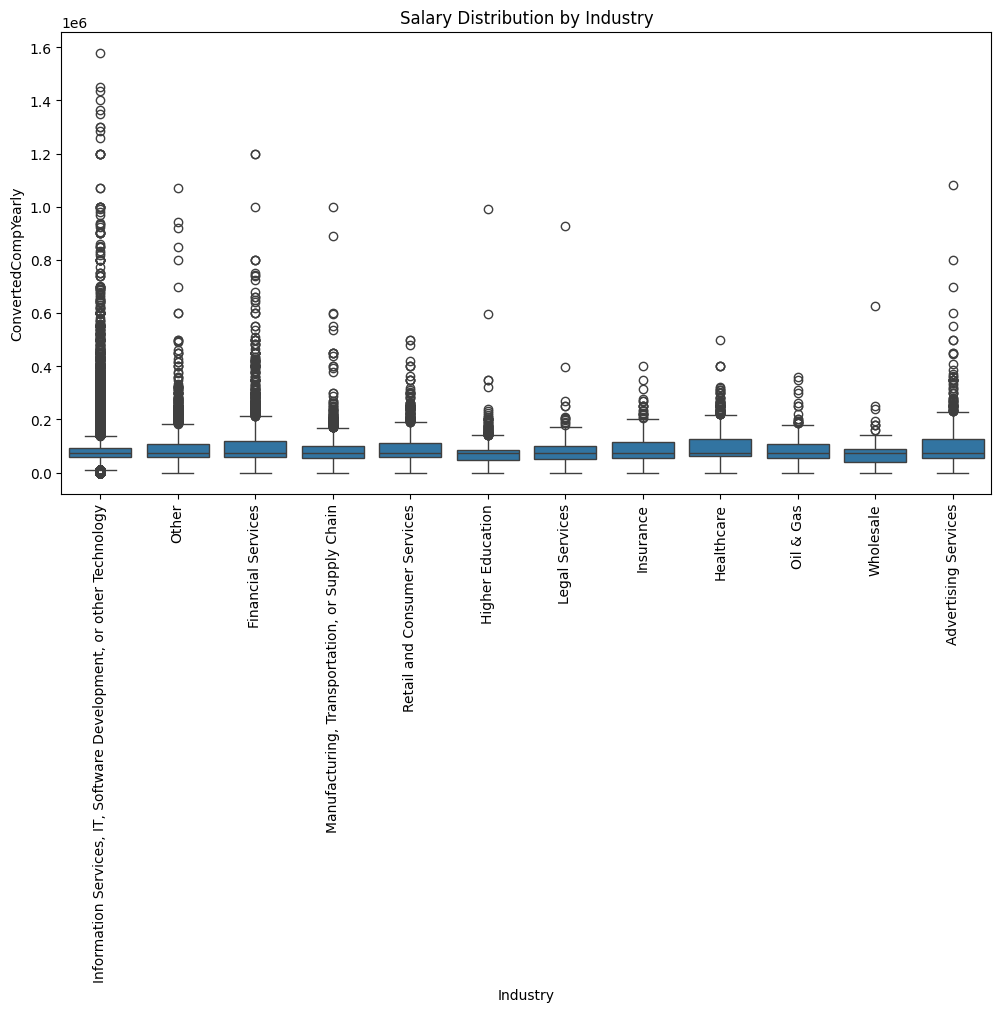

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Industry', y='ConvertedCompYearly', data=df)
plt.title('Salary Distribution by Industry')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# ANOVA Test
industries = df['Industry'].unique()
compensation_groups = [df[df['Industry'] == industry]['ConvertedCompYearly'] for industry in industries]
stat, p = stats.f_oneway(*compensation_groups)
print(f'ANOVA: F={stat:.4f}, p-value={p:.4f}')

ANOVA: F=21.4543, p-value=0.0000


**Interpretation:**
- Since the p-value is 0.000, we reject the null hypothesis, "Developers in different industries get paid the same".
- The F-value (21.4543) shows the extent of this difference, suggesting that the differences between the group means (industries' compensations) are much larger than the differences within each group.

**Conclusion:**
- There is a statistically significant difference in the average yearly compensation among the different industries.

In [ ]:
industry_df = df.groupby(['Industry', 'WorkExp']).ConvertedCompYearly.mean().reset_index()
industry_df

,Industry,WorkExp,ConvertedCompYearly
0,Advertising Services,0.0,24587.500000
1,Advertising Services,1.0,59486.717949
2,Advertising Services,2.0,48519.674419
3,Advertising Services,3.0,68601.807692
4,Advertising Services,4.0,85670.868421
...,...,...,...
520,Wholesale,34.0,97576.500000
521,Wholesale,35.0,110000.000000
522,Wholesale,37.0,162000.000000
523,Wholesale,38.0,53545.000000


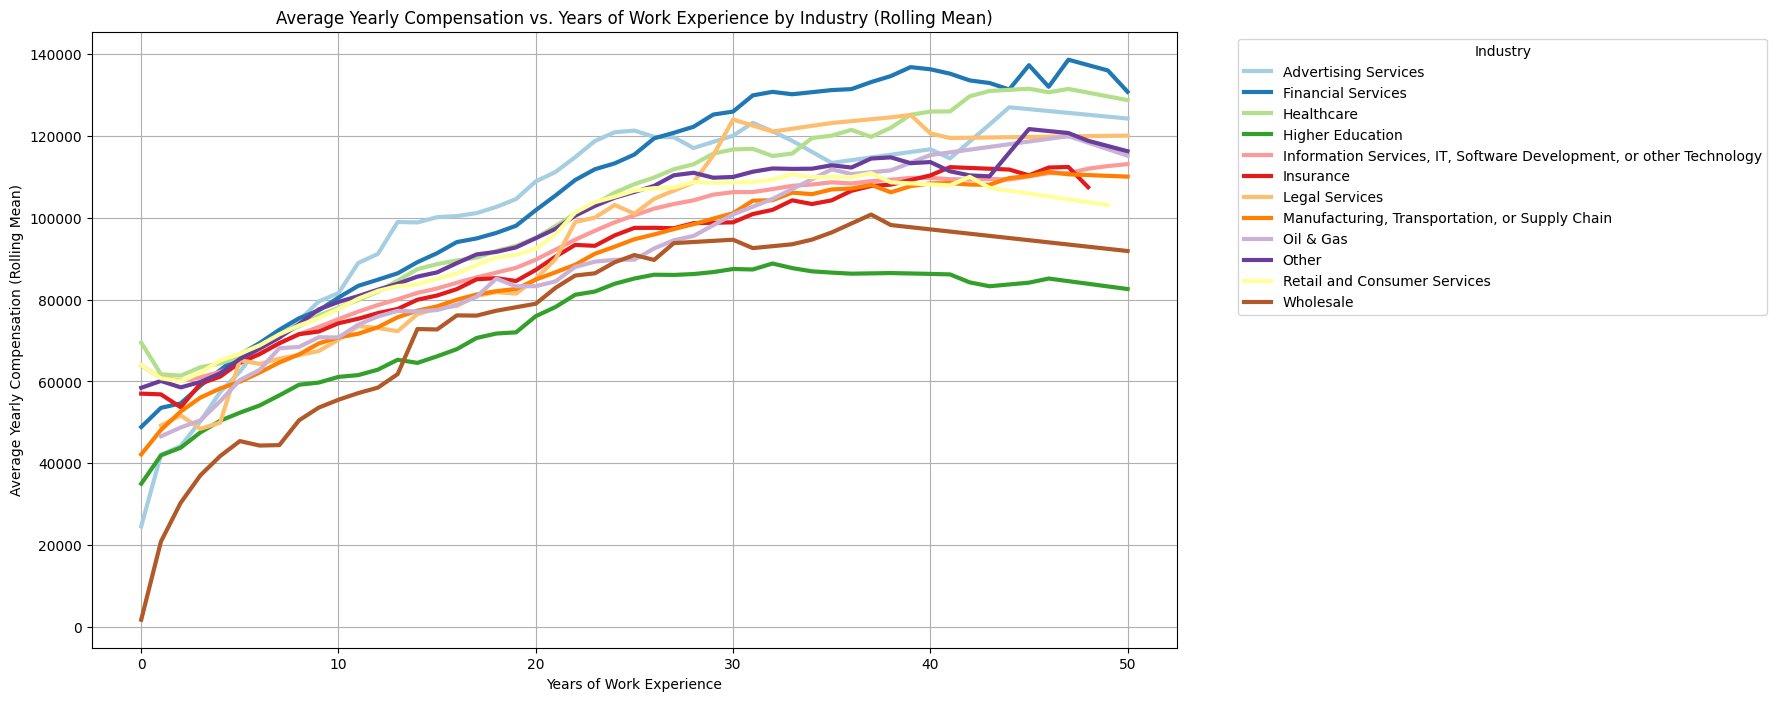

In [ ]:
window_size = 20
industry_df['RollingMean'] = industry_df.groupby('Industry')['ConvertedCompYearly'].transform(lambda x: x.rolling(window_size, 1).mean())

num_industries = industry_df['Industry'].nunique()
palette = sns.color_palette("Paired", num_industries)

# Create a line plot for each industry with distinct colors
plt.figure(figsize=(14, 8))

# Loop through each industry and plot its rolling mean data
for i, industry in enumerate(industry_df['Industry'].unique()):
    industry_data = industry_df[industry_df['Industry'] == industry]
    plt.plot(industry_data['WorkExp'], industry_data['RollingMean'], label=industry, color=palette[i], linewidth=3)

# Adding labels and title
plt.xlabel('Years of Work Experience')
plt.ylabel('Average Yearly Compensation (Rolling Mean)')
plt.title('Average Yearly Compensation vs. Years of Work Experience by Industry (Rolling Mean)')
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Hypothesis: people from non-traditional routes will find it harder to get a job

In [ ]:
unemployed = pd.read_csv('survey_data_clean_unemployed.csv')

In [ ]:
unemployed.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,Country,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WebframeHaveWorkedWith,MiscTechHaveWorkedWith,ToolsTechHaveWorkedWith,NEWCollabToolsHaveWorkedWith,AISearchHaveWorkedWith,AIDevHaveWorkedWith,NEWSOSites,SOVisitFreq,SOPartFreq,SOAI,AISelect,AISent,AIAcc,AIBen,AIToolCurrently Using,ICorPM,WorkExp,Industry,ConvertedCompYearly
0,10,I am a developer by profession,25-34 years old,"Not employed, but looking for work","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,edX;Udemy;Pluralsight;Coursera;Udacity,6.0,0.0,"Developer, full-stack",20 to 99 employees,I have some influence,Investigate,India,HTML/CSS;Java;JavaScript;Python;SQL;TypeScript,Cloud Firestore;MongoDB;MySQL;PostgreSQL;SQLite,Amazon Web Services (AWS);Firebase;Google Clou...,Angular;Express;NestJS;React,.NET (5+) ;.NET Framework (1.0 - 4.8),Docker;npm;Vite;Webpack;Yarn,Visual Studio Code,Bing AI;ChatGPT,AWS CodeWhisperer;GitHub Copilot;Tabnine,Stack Overflow;Stack Exchange,A few times per week,Less than once per month or monthly,AI could assist solving communication issues p...,Yes,Indifferent,Other (please explain);Increase productivity;G...,Neither trust nor distrust,Writing code;Debugging and getting help,Individual contributor,0.0,"Information Services, IT, Software Development...",0.0
1,59,"I am not primarily a developer, but I write co...",18-24 years old,"Not employed, but looking for work;Student, fu...","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Other online resources ...,Formal documentation provided by the owner of ...,Udemy,4.0,0.0,Student,20 to 99 employees,I have some influence,Investigate,Netherlands,C;C++;Java;Julia;Python;Zig,PostgreSQL,Amazon Web Services (AWS),React,CUDA;NumPy,Cargo;CMake;Google Test;Make,CLion;Emacs;Neovim;Visual Studio Code,ChatGPT,GitHub Copilot,Stack Overflow;Stack Exchange;Collectives on S...,Daily or almost daily,A few times per month or weekly,I sincerely hope that AI tools are not used to...,"No, and I don't plan to",Favorable,Increase productivity;Greater efficiency;Speed...,Somewhat trust,Writing code,Individual contributor,0.0,"Information Services, IT, Software Development...",0.0
2,68,I am a developer by profession,35-44 years old,"Not employed, but looking for work","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,Other,10.0,0.0,"Developer, full-stack",20 to 99 employees,I have some influence,Investigate,China,HTML/CSS;JavaScript;TypeScript,MongoDB;PostgreSQL,Google Cloud;Heroku,Express;Node.js;React,Ionic,Docker;Homebrew;Kubernetes;npm;Pip;pnpm;Webpac...,Goland;Visual Studio Code,ChatGPT,GitHub Copilot,Stack Overflow,Multiple times per day,Multiple times per day,Use API improve code review,"No, but I plan to soon",Unsure,Increase productivity;Greater efficiency;Speed...,Somewhat distrust,Writing code,Individual contributor,0.0,"Information Services, IT, Software Development...",0.0
3,70,I am a developer by profession,25-34 years old,"Not employed, but looking for work","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Other online resources ...,Formal documentation provided by the owner of ...,Udemy,8.0,0.0,"Developer, front-end",20 to 99 employees,I have some influence,Investigate,Spain,HTML/CSS;JavaScript;TypeScript,PostgreSQL;SQLite,Digital Ocean;Hetzner;Vercel,Next.js;React;Remix,.NET (5+) ;.NET Framework (1.0 - 4.8),Docker;Godot;Yarn,Visual Studio Code,ChatGPT,GitHub Copilot,Stack Overflow;Stac

In [ ]:
school_unemployed = unemployed[unemployed['LearnCode'].str.contains('School')]
non_school_unemployed = unemployed[~unemployed['LearnCode'].str.contains('School')]
print(school_unemployed.shape)
print(non_school_unemployed.shape)

(1867, 39)
(2311, 39)


In [ ]:
school_employed = df[df['LearnCode'].str.contains('School')]
non_school_employed = df[~df['LearnCode'].str.contains('School')]
print(school_employed.shape)
print(non_school_employed.shape)

(32187, 37)
(31427, 37)


In [ ]:
# Employment rates
num_employed_school = len(school_employed)
num_employed_non_school = len(non_school_employed)

num_unemployed_school = len(school_unemployed)
num_unemployed_non_school = len(non_school_unemployed)

# Total number of people from school and non-school backgrounds
total_school = num_employed_school + num_unemployed_school
total_non_school = num_employed_non_school + num_unemployed_non_school

# Employment rates
rate_employed_school = num_employed_school / total_school
rate_employed_non_school = num_employed_non_school / total_non_school

print(f"Employment rate (School): {rate_employed_school:.2f}")
print(f"Employment rate (Non-School): {rate_employed_non_school:.2f}")


Employment rate (School): 0.95
Employment rate (Non-School): 0.93


In [ ]:
# Counts of employed and observations for both groups
counts = [num_employed_school, num_employed_non_school]
num_obs = [total_school, total_non_school]

z_stat, p_val = proportions_ztest(counts, num_obs, alternative='larger')

print(f"Z-Statistic: {z_stat:.2f}")
print(f"P-Value: {p_val:.4f}")


Z-Statistic: 7.40
P-Value: 0.0000


Interpretation:
- The p-value is significantly less than 0.05, we reject the null hypothesis (that there would be no difference between employment rates).
- This provides strong evidence that the employment rate for people from non-traditional routes (non-school) is lower than for those from traditional routes (school).
- Therefore, the idea that people from non-traditional routes find it harder to get a job is supported by the data.

In [ ]:
# If more time, would have looked at these!!

In [ ]:
# Hypothesis: Developers from traditional routes will have experience with a wider range of technologies

In [ ]:
# Hypothesis: Some technologies are more sought after by employers than others

## Task 3:
Investigate potential correlations in the dataset, explaining what each correlation means in the context of your problem. If applicable, you can perform a basic regression analysis or something similar.

In [ ]:
# Create a dataset of full-time employees
full_time = df[~df['Employment'].str.contains('Employed, part-time')]

<Axes: >

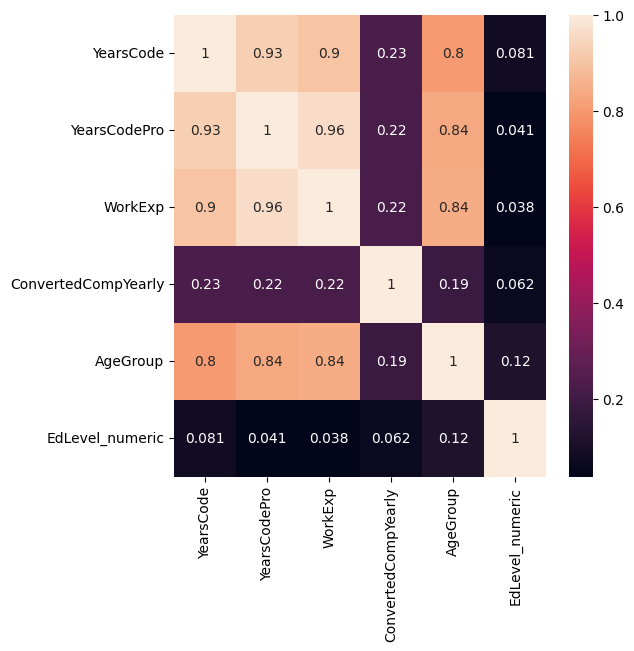

In [ ]:
# Investigate potential correlation in dataset for ft employees
heatmap_data = full_time[['YearsCode','YearsCodePro','WorkExp','ConvertedCompYearly','AgeGroup','EdLevel_numeric']]
plt.figure(figsize = (6,6))
correlation_matrix = heatmap_data.corr()
sns.heatmap(data = correlation_matrix, annot = True)

### Observations:
Based on the variables that we used for the heatmap we observed some correlations that we beleive are important to highlight.
- There is a high positive correlation between work experience and age group.
- There shows a high positive correlation between the amount of years you've coded for and the work experience.
- There is very little correlation between salary and other factors such as education level.


## Task 4:
Translate your analytical insights into potential solutions or recommendations for the identified problem. You should clearly demonstrate how you moved from data to insights.


# Analysis summary

## Steps:
- Our data was collected and filtered to exclude part-time employed individuals, focusing on full-time workers for more relevant insights.
- We then conducted a correlation matrix using Heatmap, which was used to examine the relationships between years of coding experience, professional coding experience, work experience, annual compensation, age groups, and education levels and how this all has relevance to one another.
- We performed multiple statistical tests to test our hypotheses (please see below).

## Correlation
- There was a positive correlation between 'YearsCodePro' and 'WorkExperience' as the significance level was '0.96'.  
- There was also a strong positive correlation between age, years coding as a professional and work experience
- Although there was little correlation shown here between education level and salary, our statistical tests showed that this was statistically significant.


# Statistical tests summary and recommendations

## Hypotheses and findings:
1. The higher the education level, the more you get paid: using the anova and Tukey tests, we found that in most cases this was true and statistically significant.
2. People from traditional routes get paid more than those from non-traditional: t-test showed that people who took a traditional route to coding get paid more than those taking a non-school route.
3. The more years you have worked, the more you will get paid: we calculated the Pearson Correlation Co-effficient and found that there is a significant positive correlation between years of work experience and salary.
4. Developers in different industries get paid differently: The anova test and the Kruskal-Wallis H-statistic both showed a statistically significant difference between salaries in different industries.
5. People from non-traditional routes will find it harder to get a job: the z-test showed that the proportion of people unemployed and looking for work from non-traditional routes was more than those from traditional routes and that the difference was significant.

## Recommendations for people learning to code:
- Industry plays a significant role in determining compensation levels. If you are looking for a high level of compensation, think about joining the financial services sector, health care or advertising. Developers working in higher education receive the least compensation.
- People following a traditional school-based route will enable you to gain employment more easily.
- If following a non-traditional route, ensure that your training provider offers adequate job support.
- Although a degree is not necessary to get a software developer role, our tests show that people with a higher level of education generally get paid more.


## Recomendations for training providers:
- Statistically, people going through non-traditional routes will find it more difficult to gain employment. Ensure that you provide adequate job support as part of your programme.
- Ensure there is adequate employer engagement with your programme so that participants from your course can be matched with employers.




